In [1]:
import numpy as np
import setting 
setting.load()
import noc
from scipy.integrate import odeint
from noc.gramians import obsv, ctrl
from noc.simulate import ou_process 
import matplotlib.pyplot as plt
import noc.plotting as plotting 
plotting.load()

In [2]:
w = np.loadtxt("../data/w")
n = np.shape(w)[0]
a = w - np.eye(n)
dt = 1e-3
tau = 20e-3
k = 3
keep = 8

In [3]:
def simulate(a, b, c, inp, duration):
    ts = np.linspace(0,duration, int(duration/dt) + 1)
    n = np.shape(a)[0]
    z = a.T / tau
    def f(x,t):
        inpx = b.dot(inp(t)).T
        dx = x.dot(z)
        return (dx + (inpx / tau))
    xs = odeint(f, np.zeros(n), ts)
    return ts, xs.dot(c.T)

In [4]:
# balanced truncation 
def balanced_truncation(a, b, c, keep):
    p = ctrl(a,b) 
    q = obsv(a,c) 
    u, s, _ = np.linalg.svd(p) 
    ll = (u * np.sqrt(s).reshape(1,-1)).T
    u, s, _ = np.linalg.svd(q)
    rr =  (u * np.sqrt(s).reshape(1,-1)).T
    srt = ll.dot(rr.T)
    u, svals, vt = np.linalg.svd(srt)
    hankel_svals = svals
    hankel_accuracy = np.flip(np.cumsum(np.flip(svals)))
    u = u[:,0:keep]
    vt = vt[0:keep,:]
    svals = svals[0:keep]
    tl = ((1 / np.sqrt(svals)).reshape(-1,1) * vt).dot(rr)
    tr = ll.T.dot(u) * (1 / np.sqrt(svals)).reshape(1,-1) 
    a_hat = tl.dot(a.dot(tr))
    b_hat = tl.dot(b)
    c_hat = c.dot(tr)
    return a_hat, b_hat, c_hat, hankel_svals, hankel_accuracy

q = obsv(a)
u, _, _ = np.linalg.svd(q)
b = u[:,0:k]

p = ctrl(a)
u, _, _ = np.linalg.svd(p)
c = u[:,0:k].T
a_hat, b_hat, c_hat, hankel_svals, hankel_accuracy = balanced_truncation(a,b,c,8)

In [5]:
duration = 0.3
inp, inp_fun = ou_process(k, 1e-4, tau, duration)
ts, true_xs = simulate(a,b,c,inp_fun,duration)
_, reduced_xs = simulate(a_hat,b_hat,c_hat,inp_fun,duration)

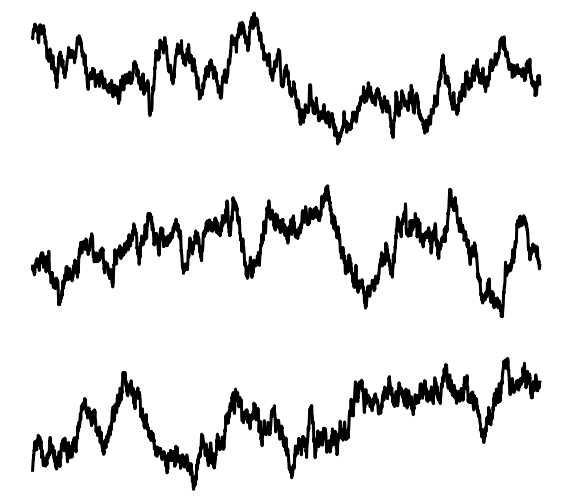

In [6]:
fig = plt.figure(figsize=(10, 3*3))
fig.patch.set_alpha(0)
axes = fig.subplots(3,1,sharex=True)
axes[2].set_ylabel("time[s]")
for i, ax in enumerate(axes):
    ax.plot(inp[:,i],color="k",linewidth=3)
    ax.axis("off")
plt.show()

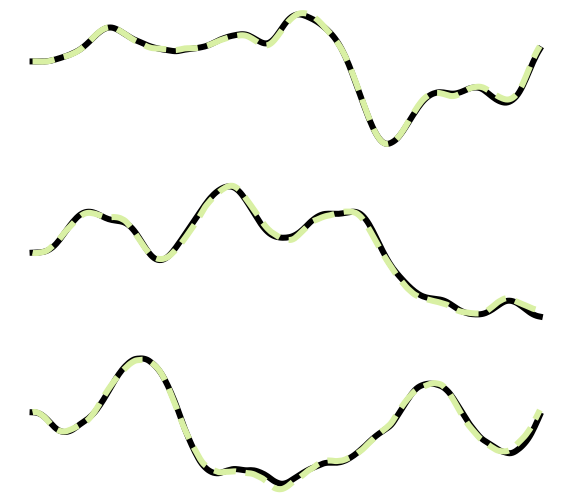

In [7]:
fig = plt.figure(figsize=(10, 3*3))
fig.patch.set_alpha(0)
axes = fig.subplots(3,1,sharex=True)
axes[2].set_ylabel("time[s]")
for i, ax in enumerate(axes):
    ax.plot(ts,true_xs[:,i],color="k",linewidth=6)
    ax.plot(ts,reduced_xs[:,i],"--",color="#d9f0a4",linewidth=6)
    ax.axis("off")
plt.show()